# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [282]:
17

17

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [283]:
import pandas as pd
import numpy as np
import scipy as sp
import os
import time

In [284]:
#Visualization related imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.ticker import ScalarFormatter
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Transformations related imports
from scipy.stats import boxcox

In [356]:
# Modeling related imports
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import make_scorer

from sklearn import set_config
set_config(display="diagram")

In [286]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [287]:
bank_df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [288]:
bank_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [289]:
## Some utility functions for data understanding

# Display the standard details like head(), info(), describe() on the given dataframe
def display_standard_details(df):
    display(df.head())
    display(df.info())
    display(df.describe())
    
# Utility aggregate function
def _get_null_pct(col):
    return "{:.2f}%".format(col.isna().sum()*100/col.shape[0])

# Utility function: Get unique column values
def _get_unique_vals(col):
    return col.unique()

def _get_col_type(col):
    return col.dtype

# Display unique values in each column, number of unique values, percentage of null values
# This information can be used while cleaning/preparing the data
def display_meta_details(df):
    meta_df = df.agg([_get_col_type, 'nunique', _get_unique_vals, _get_null_pct]).T
    meta_df.columns = ['Type', 'Num-Unique-Values', 'Unique-Values', '%-of-Nulls']
    display(meta_df)


In [290]:
display_standard_details(bank_df)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

None

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [291]:
display_meta_details(bank_df)

,Type,Num-Unique-Values,Unique-Values,%-of-Nulls
age,int64,78,"[56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 5...",0.00%
job,object,12,"[housemaid, services, admin., blue-collar, tec...",0.00%
marital,object,4,"[married, single, divorced, unknown]",0.00%
education,object,8,"[basic.4y, high.school, basic.6y, basic.9y, pr...",0.00%
default,object,3,"[no, unknown, yes]",0.00%
housing,object,3,"[no, yes, unknown]",0.00%
loan,object,3,"[no, yes, unknown]",0.00%
contact,object,2,"[telephone, cellular]",0.00%
month,object,10,"[may, jun, jul, aug, oct, nov, dec, mar, apr, ...",0.00%
day_of_week,object,5,"[mon, tue, wed, thu, fri]",0.00%


#### Outcome of Problem 3:

From the above meta details, it is clear that no column has any missing values, which is good.

Regarding converting to a different data-type, I don't see a need to do that for any column.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

#### Business Objective:
The dataset contains information from direct marketing campaigns of a Portuguese bank. It contains 3 types of information related to the clients:
(a) Client personal information like Age, Job, Marital status, etc
(b) Information pertaining to this client in the Current campaign
(c) Information pertaining to this client in the previous campaings

The business objective of the bank is very clear: Whether a given customer will subscribe or not, to the Term Deposit product that the bank is trying to sell.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [292]:
target_map = {'no':0, 'yes':1}
target_rev_map = {0:'no', 1:'yes'}

X = bank_df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']]
y = bank_df['y'].map(target_map)

# there are only 3 records with X['default'] = 'yes' out of thousands of records. 
# This is causing issues with cross-validation when the validation set doesn't contain 
# one of those; the transformer is confused. Deleting them
recs_to_drop_ind = X.loc[X['default']=='yes'].index
X = X.drop(index=recs_to_drop_ind)
y = y.drop(index=recs_to_drop_ind)

onehot_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']

ohe_transformer = make_column_transformer(
                            (OneHotEncoder(drop = 'if_binary'), onehot_cols),
                            remainder=StandardScaler())



### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [293]:
# Do 70/30 Train/test split
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234, stratify=y)

print("Trainset size:\t{}, {}".format(X_train.shape, y_train.shape))
print("Testset size:\t{}, {}".format(X_test.shape, y_test.shape))

Trainset size:	(28829, 7), (28829,)
Testset size:	(12356, 7), (12356,)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [294]:
# Baseline performance any classifier should aim to beat is 50%.
# This is because there are 2 classes in the target variable. Anyone doing a random guess whether a client will
# subscribe to the term deposit will achieve 50% success rate. 
# So, a predictive classifier should atleast be better than 50%, to be a useful tool

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [295]:
model1 = Pipeline([('transformer', ohe_transformer),
                     ('lgr', LogisticRegression(random_state=1234))])
t0 = time.time()
model1.fit(X_train, y_train)
t1 = time.time()

model1_fittime = "{} sec".format(np.round((t1 - t0), decimals=2))
display(model1)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('lgr', LogisticRegression(random_state=1234))])

### Problem 9: Score the Model

What is the accuracy of your model?

In [296]:
# Utility functions
def print_train_test_evaluation(estimator, X_trainset, y_trainset, X_testset, y_testset, descr):
    curmodel_acc_train = round(accuracy_score(y_trainset, estimator.predict(X_trainset))*100, 2)
    curmodel_acc_test  = round(accuracy_score(y_testset, estimator.predict(X_testset))*100, 2)
    curmodel_f1_test   = round(f1_score(y_testset, estimator.predict(X_testset), average='weighted')*100, 2)

    print(f'{descr} accuracy on train-data:\t{curmodel_acc_train}')
    print(f'{descr} accuracy on test-data:\t{curmodel_acc_test}')
    print(f'{descr} F1 score on test-data:\t{curmodel_f1_test}')
    
    y_curpreds = estimator.predict(X_testset)
    print(classification_report(y_testset, y_curpreds))
    
    return curmodel_acc_train,curmodel_acc_test,curmodel_f1_test

In [297]:
model1_train_acc, model1_test_acc, model1_f1_score = \
    print_train_test_evaluation(model1, X_train, y_train, X_test, y_test, "Model 1: Basic logistic regression")

Model 1: Basic logistic regression accuracy on train-data:	88.73
Model 1: Basic logistic regression accuracy on test-data:	88.73
Model 1: Basic logistic regression F1 score on test-data:	83.44
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10964
           1       0.00      0.00      0.00      1392

    accuracy                           0.89     12356
   macro avg       0.44      0.50      0.47     12356
weighted avg       0.79      0.89      0.83     12356



In [298]:
# I'll maintain results of the models in the below list of lists
# Each entry will be a list with format: 
#   ['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy']
results = []

In [299]:
results.append(['Basic Logistic Regression', model1_fittime, model1_train_acc, model1_test_acc])

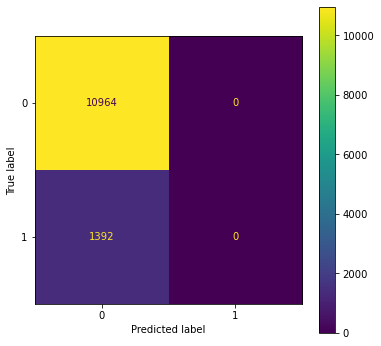

In [300]:
fig, axes = plt.subplots( figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, model1.predict(X_test), ax=axes);

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [301]:
# Model 2: kNN
model2 = Pipeline([('transformer', ohe_transformer),
                     ('knn', KNeighborsClassifier())])
t0 = time.time()
model2.fit(X_train, y_train)
t1 = time.time()

model2_fittime = "{} sec".format(np.round((t1 - t0), decimals=2))
display(model2)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('knn', KNeighborsClassifier())])

In [302]:
model2_train_acc, model2_test_acc, model2_f1_score = \
    print_train_test_evaluation(model2, X_train, y_train, X_test, y_test, "Model 2: Basic kNN")

Model 2: Basic kNN accuracy on train-data:	89.08
Model 2: Basic kNN accuracy on test-data:	87.71
Model 2: Basic kNN F1 score on test-data:	83.97
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     10964
           1       0.28      0.06      0.10      1392

    accuracy                           0.88     12356
   macro avg       0.59      0.52      0.52     12356
weighted avg       0.82      0.88      0.84     12356



In [303]:
results.append(['Basic kNN', model2_fittime, model2_train_acc, model2_test_acc])

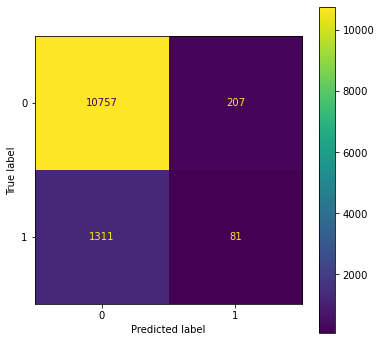

In [304]:
fig, axes = plt.subplots( figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, model2.predict(X_test), ax=axes);

In [305]:
# Model 3: Decision Tree
model3 = Pipeline([('transformer', ohe_transformer),
                     ('dt', DecisionTreeClassifier(random_state=1234))])
t0 = time.time()
model3.fit(X_train, y_train)
t1 = time.time()

model3_fittime = "{} sec".format(np.round((t1 - t0), decimals=2))
display(model3)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('dt', DecisionTreeClassifier(random_state=1234))])

In [306]:
model3_train_acc, model3_test_acc, model3_f1_score = \
    print_train_test_evaluation(model3, X_train, y_train, X_test, y_test, "Model 3: Basic DecisionTree")

Model 3: Basic DecisionTree accuracy on train-data:	91.82
Model 3: Basic DecisionTree accuracy on test-data:	86.31
Model 3: Basic DecisionTree F1 score on test-data:	83.67
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     10964
           1       0.23      0.10      0.14      1392

    accuracy                           0.86     12356
   macro avg       0.56      0.53      0.53     12356
weighted avg       0.82      0.86      0.84     12356



In [307]:
results.append(['Basic Decision-tree', model3_fittime, model3_train_acc, model3_test_acc])

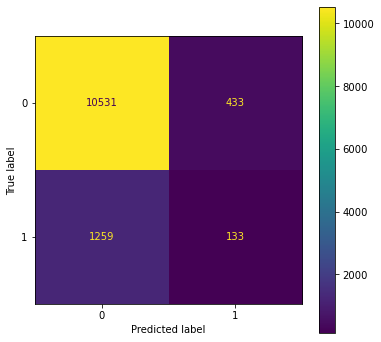

In [308]:
fig, axes = plt.subplots( figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, model3.predict(X_test), ax=axes);

In [309]:
# Model 4: SVM Model
model4 = Pipeline([('transformer', ohe_transformer),
                     ('svc', SVC(random_state=1234))])
t0 = time.time()
model4.fit(X_train, y_train)
t1 = time.time()

model4_fittime = "{} sec".format(np.round((t1 - t0), decimals=2))
display(model4)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])])),
                ('svc', SVC(random_state=1234))])

In [310]:
model4_train_acc, model4_test_acc, model4_f1_score = \
    print_train_test_evaluation(model4, X_train, y_train, X_test, y_test, "Model 4: Basic SVM")

Model 4: Basic SVM accuracy on train-data:	88.87
Model 4: Basic SVM accuracy on test-data:	88.69
Model 4: Basic SVM F1 score on test-data:	83.68
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10964
           1       0.44      0.01      0.02      1392

    accuracy                           0.89     12356
   macro avg       0.66      0.51      0.48     12356
weighted avg       0.84      0.89      0.84     12356



In [311]:
results.append(['Basic SVM', model4_fittime, model4_train_acc, model4_test_acc])

In [312]:
results_df = pd.DataFrame(data=results, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])

In [313]:
display(results_df)

,Model,Train Time,Train Accuracy,Test Accuracy
0,Basic Logistic Regression,0.29 sec,88.73,88.73
1,Basic kNN,0.05 sec,89.08,87.71
2,Basic Decision-tree,0.38 sec,91.82,86.31
3,Basic SVM,24.9 sec,88.87,88.69


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Before going to tune the hyper-parameters, let's look at the correct performance evaluation metric for this dataset

#### Performance Evaluation metric
For this dataset, just looking at the train/test Accuracy scores is a little mis-leading. 

For example, look at Model 1 above (Logistic regression): From it's confusion matrix, we can wee that it predicted everything as class 0 (the True-positives and False-positives are 0), yet it shows a 88.73% accuracy.

More importantly, the target classes are unevenly distributed. 

For these reasons, the correct performance metric is using F1-score. If we want to penalize hard on not predicting the positive-class correctly, one can use the macro average of the F1-score.

I'm going to use the Weighted Average of the F1-score, that gives weights proportionate to target class distribution.

In [355]:
f1 = make_scorer(f1_score , average='weighted')

In [316]:
# Utility functions
def print_train_test_evaluation_on_f1score(estimator, X_trainset, y_trainset, X_testset, y_testset, descr):
    curmodel_f1_train  = round(f1_score(y_trainset, estimator.predict(X_trainset), average='weighted')*100, 2)
    curmodel_f1_test   = round(f1_score(y_testset, estimator.predict(X_testset), average='weighted')*100, 2)

    print(f'{descr} F1 score on train-data:\t{curmodel_f1_train}')
    print(f'{descr} F1 score on test-data:\t{curmodel_f1_test}')
    
    y_curpreds = estimator.predict(X_testset)
    print(classification_report(y_testset, y_curpreds))
    
    return curmodel_f1_train,curmodel_f1_test

#### To determine which features are important to find whether to keep a specific feature or not,  I will perform permutation feature importance on the train and test data.

In [317]:
def display_permutation_importance_features(est, X_trainset, y_trainset, X_testset, y_testset, n_rep=30, descr=''):
    print('Permutation importance on train dataset on {}'.format(descr))
    r = permutation_importance(est, X_trainset, y_trainset, n_repeats=n_rep)
    features = X_trainset.columns
    for i in r.importances_mean.argsort()[::-1]:
            print(f"{features[i]:<8}"
                  f" {r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")
    # For reducing computational time, I'm not performing this on test-data

#### Feature importance on Model1
Again, looking at the confusion matrix, this model is predicting everything as target class 'no'. This looks more like a 'no-skill classifier'. I don't think adding or removing features will make difference for this model. Let's confirm that

In [318]:
display_permutation_importance_features(model1, X_train, y_train, X_test, y_test, descr='Model1')

Permutation importance on train dataset on Model1
age      0.000 +/- 0.000
marital  0.000 +/- 0.000
education 0.000 +/- 0.000
job      0.000 +/- 0.000
loan     0.000 +/- 0.000
housing  0.000 +/- 0.000
default  -0.000 +/- 0.000


#### Conclusion on Feature importance on model1
As expected, this shows no features are really important for Model 1

#### Feature importance on Model2
Let's see which features are important for Model 2

In [319]:
display_permutation_importance_features(model2, X_train, y_train, X_test, y_test, descr='Model2')

Permutation importance on train dataset on Model2
age      0.013 +/- 0.000
education 0.009 +/- 0.001
job      0.008 +/- 0.001
housing  0.006 +/- 0.001
marital  0.004 +/- 0.001
default  0.003 +/- 0.000
loan     0.002 +/- 0.000


#### Feature importance on Model3
Let's see which features are important for Model 3

In [320]:
display_permutation_importance_features(model3, X_train, y_train, X_test, y_test, descr='Model3')

Permutation importance on train dataset on Model3
age      0.064 +/- 0.001
job      0.060 +/- 0.001
education 0.058 +/- 0.001
marital  0.030 +/- 0.001
housing  0.022 +/- 0.001
default  0.018 +/- 0.001
loan     0.018 +/- 0.001


#### Feature importance on Model4
Let's see which features are important for Model 4

In [321]:
display_permutation_importance_features(model4, X_train, y_train, X_test, y_test, descr='Model4')

Permutation importance on train dataset on Model4
age      0.002 +/- 0.000
education 0.001 +/- 0.000
job      0.001 +/- 0.000
loan     0.000 +/- 0.000
housing  0.000 +/- 0.000
marital  0.000 +/- 0.000
default  0.000 +/- 0.000


#### Conclusion on Feature Engineering based on permutation importance



As mentioned, our Model 1 is mostly a no-skill model as it happens to predict everything as target class 0.
In Model 2 and 3, all the features are contributing to the prediction to certain degree. 
Model 4 only depends on age, education and job.

I will continue to use all the features for the rest of the exercise. The hyper-parameter tuning on the basic models might need additional features for better prediction.

#### Hyper-parameter tuning
Now, let's do some hyper-parameter tuning on Model 1 through 4. We will call these Models 5 through 8

In [322]:
# Tune logistic regression hyper-parameters 
model5_param_dict = {'lgr__C': np.logspace(-5, .5, 10),
                    'lgr__max_iter': [200, 300]
                    }

In [323]:
onehot_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']

ohe_transformer = make_column_transformer(
                            (OneHotEncoder(), onehot_cols),
                            remainder=StandardScaler())

In [357]:
model5 = Pipeline([('transformer', ohe_transformer),
                     ('lgr', LogisticRegression(random_state=1234))])


In [358]:
model5_grid = GridSearchCV(model5, model5_param_dict, scoring=f1, cv=2, \
                         verbose=0, return_train_score=True, n_jobs=-1)


In [359]:
%%time
t0 = time.time()
model5_grid.fit(X_train, y_train)
t1 = time.time()

model5_fittime = "{} sec".format(np.round((t1 - t0), decimals=2))

CPU times: user 347 ms, sys: 27.3 ms, total: 374 ms
Wall time: 952 ms


In [360]:
print(model5_grid.best_params_)

{'lgr__C': 1e-05, 'lgr__max_iter': 200}


In [361]:
model5_train_f1, model5_test_f1 = print_train_test_evaluation_on_f1score(model5_grid.best_estimator_, X_train, y_train, X_test, y_test, 
                                                                           "Model 5(Tuned Logistic regression)")

Model 5(Tuned Logistic regression) F1 score on train-data:	83.44
Model 5(Tuned Logistic regression) F1 score on test-data:	83.44
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10964
           1       0.00      0.00      0.00      1392

    accuracy                           0.89     12356
   macro avg       0.44      0.50      0.47     12356
weighted avg       0.79      0.89      0.83     12356



In [362]:
# I'll maintain results of the tuned models in the below list of lists
# Each entry will be a list with format: 
#   ['Model', 'Parameters', Train Time', 'Train F1-score', 'Test F1-score']
results_with_f1score = []

In [363]:
results_with_f1score.append(['Tuned Logistic Regr', '{}'.format(model5_grid.best_params_), model5_fittime, \
                             model5_train_f1, model5_test_f1])

In [364]:
#kNN grid search
k_range = list(range(10, 60, 10))
model6_param_dict = {'knn__n_neighbors': k_range}

In [365]:
model6 = Pipeline([('transformer', ohe_transformer),
                     ('knn', KNeighborsClassifier())])


In [366]:
%%time
model6_knn_grid = GridSearchCV(model6, model6_param_dict, scoring=f1, cv=2, verbose=0, n_jobs=-1)
t0 = time.time()
model6_knn_grid.fit(X_train, y_train)
t1 = time.time()

model6_fittime = "{} sec".format(np.round((t1 - t0), decimals=2))


CPU times: user 134 ms, sys: 113 ms, total: 246 ms
Wall time: 1min 9s


In [367]:
print(model6_knn_grid.best_params_)

{'knn__n_neighbors': 20}


In [368]:
model6_train_f1, model6_test_f1 = print_train_test_evaluation_on_f1score(model6_knn_grid.best_estimator_, X_train, y_train, X_test, y_test, 
                                                                           "Model 6(Tuned kNN)")

Model 6(Tuned kNN) F1 score on train-data:	84.27
Model 6(Tuned kNN) F1 score on test-data:	83.74
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10964
           1       0.36      0.02      0.04      1392

    accuracy                           0.89     12356
   macro avg       0.62      0.51      0.49     12356
weighted avg       0.83      0.89      0.84     12356



In [369]:
results_with_f1score.append(['Tuned kNN', '{}'.format(model6_knn_grid.best_params_), model6_fittime, \
                             model6_train_f1, model6_test_f1])

In [370]:
#Decision tree grid search
model7_param_dict = {'dt__max_depth': [5, 10, 20, 50],
             'dt__min_samples_split': [0.05, 0.1, 0.2]}

In [371]:
model7 = Pipeline([('transformer', ohe_transformer),
                     ('dt', DecisionTreeClassifier())])

In [372]:
%%time
model7_dt_grid = GridSearchCV(model7, model7_param_dict, scoring=f1, cv=3, verbose=0, n_jobs=-1)
t0 = time.time()
model7_dt_grid.fit(X_train, y_train)
t1 = time.time()

model7_fittime = "{} sec".format(np.round((t1 - t0), decimals=2))

CPU times: user 306 ms, sys: 34.8 ms, total: 341 ms
Wall time: 514 ms


In [373]:
print(model7_dt_grid.best_params_)

{'dt__max_depth': 10, 'dt__min_samples_split': 0.05}


In [374]:
model7_train_f1, model7_test_f1 = print_train_test_evaluation_on_f1score(model7_dt_grid.best_estimator_, X_train, y_train, X_test, y_test, 
                                                                           "Model 7(Tuned Decision Tree)")

Model 7(Tuned Decision Tree) F1 score on train-data:	83.44
Model 7(Tuned Decision Tree) F1 score on test-data:	83.44
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10964
           1       0.00      0.00      0.00      1392

    accuracy                           0.89     12356
   macro avg       0.44      0.50      0.47     12356
weighted avg       0.79      0.89      0.83     12356



In [375]:
results_with_f1score.append(['Tuned Decision tree', '{}'.format(model7_dt_grid.best_params_), model7_fittime, \
                             model7_train_f1, model7_test_f1])

#### I attempted to grid-search SVM hyper-parameters, but is computationally expensive and is taking a long time

In [376]:
results_tuned_f1_df = pd.DataFrame(data=results_with_f1score, columns=['Model', 'Parameters', 'Train Time', 'Train F1 score', 'Test F1 score'])

display(results_tuned_f1_df)

,Model,Parameters,Train Time,Train F1 score,Test F1 score
0,Tuned Logistic Regr,"{'lgr__C': 1e-05, 'lgr__max_iter': 200}",0.95 sec,83.44,83.44
1,Tuned kNN,{'knn__n_neighbors': 20},69.97 sec,84.27,83.74
2,Tuned Decision tree,"{'dt__max_depth': 10, 'dt__min_samples_split':...",0.51 sec,83.44,83.44


##### Let's look at the ROC curves for these models and see if we can infer anything else

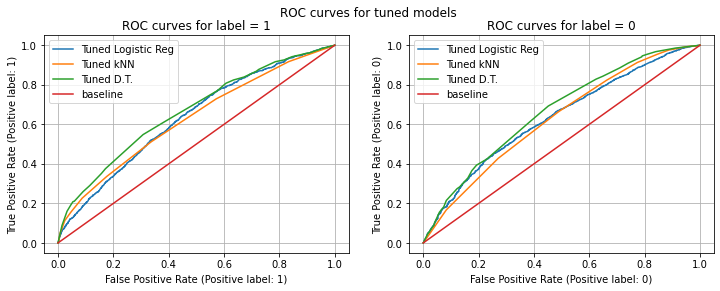

In [377]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
fig.suptitle('ROC curves for tuned models')

RocCurveDisplay.from_estimator(model5_grid.best_estimator_, X_test, y_test,  ax = ax[0], label = 'Tuned Logistic Reg')
RocCurveDisplay.from_estimator(model6_knn_grid.best_estimator_, X_test, y_test, ax = ax[0], label = 'Tuned kNN')
RocCurveDisplay.from_estimator(model7_dt_grid.best_estimator_, X_test, y_test, ax = ax[0], label = 'Tuned D.T.')
ax[0].set_title('ROC curves for label = 1')
ax[0].grid()
ax[0].plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
ax[0].legend();

RocCurveDisplay.from_estimator(model5_grid.best_estimator_, X_test, y_test,  ax = ax[1], pos_label=0, label = 'Tuned Logistic Reg')
RocCurveDisplay.from_estimator(model6_knn_grid.best_estimator_, X_test, y_test, ax = ax[1], pos_label=0, label = 'Tuned kNN')
RocCurveDisplay.from_estimator(model7_dt_grid.best_estimator_, X_test, y_test, ax = ax[1], pos_label=0, label = 'Tuned D.T.')
ax[1].set_title('ROC curves for label = 0')
ax[1].grid()
ax[1].plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
ax[1].legend();

### Conclusion

All the tuned models are performing almost equally, while kNN has a tiny bit better F1 score. 


While all the models are doing good with target-class 'no' (a.k.a target-class = 0), only the kNN model has a non-zero F1-score for target class 'yes' (a.k.a. target-class = 1). The logistic regression and decision tree based have F1-score = 0 for target class 'yes'.

##### I would recommend using kNN based model as it is able to do some amount of justice to target-class 1.

### Findings to non-technical audience

The goal of the project is to provide a predictive tool to the Portuguese bank that lets them achieve the business objective: Given certain information about a customer, estimate with high confidence whether the customer will subscribe to the Term Deposit product or not.

Our tool is able to estimate the customers who are 'not likely' to subscribe to the Term Deposit with a 94% confidence (based on target-class=0 F1 score of the recommended model). However, the tool currently only able to estimate the customers who are 'likely' to subscribe to the Term deposit with small confidence.

### Next steps and recommendations

1. Fine-tune the models further especially for target-class 'yes'. 


2. The exercise asked to use only the customer's personal information as the feature-set. There are other features related to campaigns. Build more models using these other features.


3. Only 10% of the data has target-class 'yes' and the rest 90% is 'no'. Maybe, we should use the entire data for training and use the cross-validation scheme for testing, as opposed to keeping separate set for testing


4. As we will learn in later modules, build ensemble techniques based models.

### Note

#### I haven't performed Exploratory Data Analysis as the exercise already hand-picked a subset of features and asked to jump into modeling straight